In [2]:
from dist_tools import *

%matplotlib inline

In [93]:
def get_minority_seats_cdmap(usps, year):

    sessn = {1990 : 107, 2000 : 111, 2010 : 114}[year]

    race = pd.read_sql("""SELECT
                             cd.state state, cd, 
                             CASE WHEN (1.*SUM(hispanic)/SUM(pop) > 0.5) THEN 'H'
                             WHEN (1.*SUM(black)/SUM(pop) > 0.5) THEN 'B'
                             ELSE 'W' END majority
                          FROM census_tracts_{} as tr
                          JOIN states s ON tr.state = s.fips
                          JOIN cd ON cd.sessn = {} AND
                             cd.state = tr.state AND
                             ST_Covers(cd.geom, tr.centroid)
                          WHERE s.usps = '{}'
                          GROUP BY cd.state, cd, cd.geom
                          ORDER BY cd.state, cd;
                          """.format(year, sessn, usps),
                          con = psycopg2.connect(database = "census", user = user, password = passwd,
                                                 host = "saxon.harris.uchicago.edu", port = 5432))
    
    return usps, {"H" : sum(race.majority == "H"), "B" : sum(race.majority == "B"), "T" : race.shape[0]}

In [97]:
for usps in ["NC", "VA", "PA", "CA", "FL", "TX"]: 
    for year in [1990, 2000, 2010]:
        print(get_minority_seats_cdmap(usps, year))

('NC', {'H': 0, 'B': 0, 'T': 12})
('NC', {'H': 0, 'B': 0, 'T': 13})
('NC', {'H': 0, 'B': 1, 'T': 13})
('VA', {'H': 0, 'B': 1, 'T': 11})
('VA', {'H': 0, 'B': 1, 'T': 11})
('VA', {'H': 0, 'B': 1, 'T': 11})
('PA', {'H': 0, 'B': 2, 'T': 21})
('PA', {'H': 0, 'B': 1, 'T': 19})
('PA', {'H': 0, 'B': 1, 'T': 18})
('CA', {'H': 6, 'B': 0, 'T': 52})
('CA', {'H': 10, 'B': 0, 'T': 53})
('CA', {'H': 13, 'B': 0, 'T': 53})
('FL', {'H': 2, 'B': 1, 'T': 23})
('FL', {'H': 3, 'B': 1, 'T': 25})
('FL', {'H': 3, 'B': 1, 'T': 27})
('TX', {'H': 6, 'B': 0, 'T': 30})
('TX', {'H': 7, 'B': 0, 'T': 32})
('TX', {'H': 10, 'B': 0, 'T': 36})


In [69]:
sum(race_map.majority.isin(["B", "H"]))

40

In [4]:
race_query = """SELECT
                  rn.rn, d.state, d.county cid, d.tract,
                  b01001_001e P, b01001a_001e W,
                  b01001b_001e B, b01001i_001e H
                FROM census_tracts_2015 AS g
                JOIN states AS s ON
                  g.state = s.fips
                JOIN acssf5y2015 AS d ON
                  d.state  = g.state  AND
                  d.county = g.county AND
                  d.tract  = g.tract
                JOIN (SELECT state, county, tract,
                             row_number() over (PARTITION BY state ORDER BY county, tract NULLS LAST) - 1 as rn
                      FROM census_tracts_2015) rn ON
                  g.state  = rn.state  AND
                  g.county = rn.county AND
                  g.tract  = rn.tract
                WHERE s.usps = UPPER('{}')
                ORDER BY d.state, d.county, d.tract;"""

con = psycopg2.connect(database = "census", user = user, password = passwd,
                       host = "saxon.harris.uchicago.edu", port = 5432)

race_ethnicity_df = pd.read_sql(race_query.format(usps), con, index_col = "rn")

In [181]:
def tract_race(usps):
    
    return pd.read_sql("""SELECT
                            rn.rn, d.state, d.county cid, d.tract,
                            b01001_001e pop, b01001a_001e white,
                            b01001b_001e black, b01001i_001e hispanic
                          FROM census_tracts_2015 AS g
                          JOIN states AS s ON
                            g.state = s.fips
                          JOIN acssf5y2015 AS d ON
                            d.state  = g.state  AND
                            d.county = g.county AND
                            d.tract  = g.tract
                          JOIN (SELECT state, county, tract,
                                       row_number() over (PARTITION BY state ORDER BY county, tract NULLS LAST) - 1 as rn
                                FROM census_tracts_2015) rn ON
                            g.state  = rn.state  AND
                            g.county = rn.county AND
                            g.tract  = rn.tract
                          WHERE s.usps = UPPER('{}')
                          ORDER BY d.state, d.county, d.tract;
                          """.format(usps),
                          con = psycopg2.connect(database = "census", user = user, password = passwd,
                                                 host = "saxon.harris.uchicago.edu", port = 5432),
                          index_col = "rn")


def get_minority_seats_mymap(tract_votes, paths):

    if not len(paths): return 0, 0

    seats, nmaps = 0, len(paths)
    outcomes = pd.DataFrame(columns = ["hispanic", "black", "H Frac", "H Seat", "B Frac", "B Seat", "Minority Seat"])
    
    for xi, xpath in enumerate(paths):

        map_df = pd.read_csv(xpath, names = ["rn", "region"], header = None)
        mapped_votes = tract_votes.join(map_df)
        cd_seats = mapped_votes.groupby("region").sum()
        cd_seats["H Frac"] = cd_seats["hispanic"] / cd_seats["pop"]
        cd_seats["B Frac"] = cd_seats["black"]    / cd_seats["pop"]
        cd_seats["H Seat"] = cd_seats["H Frac"] > 0.5
        cd_seats["B Seat"] = cd_seats["B Frac"] > 0.5

        cd_seats["Minority Seat"] = cd_seats["B Seat"] | cd_seats["H Seat"]
        
        outcomes = outcomes.append(cd_seats)
        
        seats = cd_seats.shape[0]

    return outcomes["Minority Seat"].astype(int).sum() / (seats * nmaps), outcomes


In [185]:
stdir = "../cluscious/res/{}/{}/*/*.csv"

metrics = {"Dynamic Radius"        : "dyn_radius",  "Inscribed Circles"      : "ehrenburg",
           "Exchange"              : "exchange",    "Population Hull"        : "hull_p",
           "Isoperimeter Quotient" : "polsby",      "Circumscribing Circles" : "reock",
           "Rohrbach"              : "rohrbach",    "Power Diagram"          : "power",
           "Split-Line"            : "split"}

seat_res = {}
for usps in ["fl"]:
    seat_res[usps] = {}
    for ti, m in metrics.items():

        tr_race_df = tract_race(usps)
        fr, seat_res[usps][m] = get_minority_seats_mymap(tr_race_df, glob.glob(stdir.format(usps, m)))
        print(usps, ti, fr)

fl Exchange 0.1164021164021164
fl Population Hull 0.1111111111111111
fl Rohrbach 0.11522633744855967
fl Isoperimeter Quotient 0.1111111111111111
fl Power Diagram 0
fl Dynamic Radius 0.10648148148148148
fl Circumscribing Circles 0.11574074074074074
fl Split-Line 0
fl Inscribed Circles 0.10699588477366255


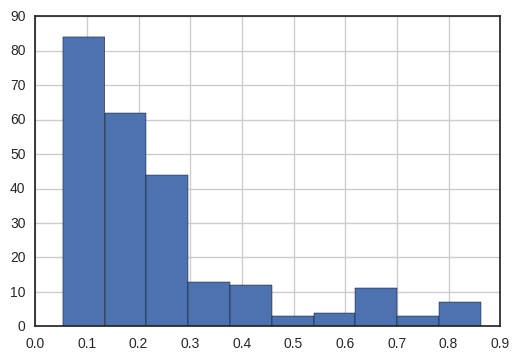

In [186]:
seat_res[usps]["ehrenburg"]["H Frac"].hist()